In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

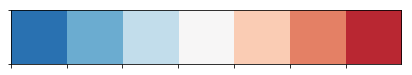

In [4]:
import seaborn as sns
sns.palplot(sns.color_palette("RdBu_r", 7))

sns.set_style("whitegrid")

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [5]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print len(df)

9779168


<p>Base com todas chuvas EXTREMAS com inicio e fim de cada chuva extrema (> 50mm em 24 horas)</p>

In [17]:
dfhr = pd.read_csv('../data/extreme_prcp.csv')
print len(dfhr)

86932


<p>Subconjunto da base principal considerando o inicio e fim das chuvas extremas (> 50mm em 24 horas)</p>

In [7]:
#dfext = pd.read_csv('../data/sudeste_extreme_prcp.csv')
#print len(dfext)

# Pré-processamento

In [20]:
dfhr['str'] = pd.to_datetime(dfhr['str'])
dfhr['end'] = pd.to_datetime(dfhr['end'])

In [21]:
dfhr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86932 entries, 0 to 86931
Data columns (total 5 columns):
id       86932 non-null int64
wsid     86932 non-null int64
str      86932 non-null datetime64[ns]
end      86932 non-null datetime64[ns]
total    86932 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 3.3 MB


In [22]:
df['mdct'] = pd.to_datetime(df['mdct'])
df['date'] = pd.to_datetime(df['date'])

strfld = ['wsnm','inme','city','prov']

for f in strfld:
    df[f] = df[f].astype(str)    

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9779168 entries, 0 to 9779167
Data columns (total 31 columns):
wsid    int64
wsnm    object
elvt    float64
lat     float64
lon     float64
inme    object
city    object
prov    object
mdct    datetime64[ns]
date    datetime64[ns]
yr      int64
mo      int64
da      int64
hr      int64
prcp    float64
stp     float64
smax    float64
smin    float64
gbrd    float64
temp    float64
tmax    float64
tmin    float64
dewp    float64
dmax    float64
dmin    float64
hmdy    float64
hmax    float64
hmin    float64
wdsp    float64
wdct    float64
gust    float64
dtypes: datetime64[ns](2), float64(20), int64(5), object(4)
memory usage: 2.3+ GB


In [24]:
# Campos não numericos e campos derivados
DES= ['wsid','wsnm','elvt','lat','lon','inme','city','prov']
INT = ['yr','mo','da','hr']
DAT = ['mdct','date']
DER = ['smax','smin','tmax','tmin','dmax','dmin','hmax','hmin']

In [25]:
# dataframe apenas com os dados continuos
dfcont = df
for f in DES + INT + DAT:    
    dfcont = dfcont.drop(f, 1)

In [26]:
# dataframe com dados continuos mas sem dados derivados
dfcsd = dfcont
for f in DER:    
    dfcsd = dfcsd.drop(f, 1)

<p>Separando apenas o conjunto de precipitações extremas. Ou seja, criando um novo dataframe filtrando apenas os dados medidos no início e fim da chuva extrema </p>

In [30]:
# Separando as chuvas (Não precisa fazer mais pois já criei um CSV com o SUBCONJUNTO) -> Usar dfext
dfext = pd.DataFrame(data=None, columns=df.columns)

for i, row in dfhr.iterrows(): 
    start = row['str']
    end = row['end']
    dfx = df[(df['mdct']>=start) & (df['mdct']<=end) & (df['wsid']==row['wsid'] )  ]    
    dfx['exid'] =  pd.Series(row['id'], index=dfx.index)    
    dfext = pd.concat([dfext, dfx]) 

/home/dedeco/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KeyboardInterrupt: 

In [66]:
dfext.to_csv('../data/sudeste_extreme_prcp.csv', sep=',', encoding='utf-8')

In [27]:
# dataframe apenas com os dados continuos (APENAS Chuvas extremas)
dfextcont = dfext
for f in DES + INT + DAT:    
    dfextcont = dfextcont.drop(f, 1)

NameError: name 'dfext' is not defined

<h3>Limpeza dos dados</h3>

<p>Vamos ver como os dados contínuos estão organizados: MÍNIMOS, MÁXIMOS, MEDIAS</p>

In [58]:
dfextcont = dfextcont.drop(dfextcont.columns[0], axis=1)

In [59]:
dfextcont.dropna(inplace=False).head(5)

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,17.2,985.2,985.6,983.8,19.7,18.9,23.1,21.9,19.7,18.4,95.0,95.0,90.0,5.4,187.0,11.5
1,15.4,983.8,985.1,983.7,21.0,20.6,21.0,20.6,19.6,18.8,97.0,98.0,95.0,1.3,221.0,11.5
2,1.4,984.3,984.4,983.8,20.8,20.3,21.1,20.6,20.6,20.2,97.0,97.0,97.0,0.7,273.0,3.0
3,3.4,984.5,984.8,984.3,20.9,20.5,21.0,20.6,20.8,20.3,97.0,97.0,97.0,1.4,128.0,2.8
4,4.6,984.5,984.5,984.1,21.0,20.5,21.0,20.5,20.9,20.4,97.0,97.0,97.0,0.8,270.0,4.1


In [60]:
dfextcont = dfextcont.apply(pd.to_numeric, errors='coerce')  

In [61]:
dfextcont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99686 entries, 0 to 101975
Data columns (total 16 columns):
prcp    55177 non-null float64
stp     99686 non-null float64
smax    99686 non-null float64
smin    99686 non-null float64
temp    99686 non-null float64
tmax    99686 non-null float64
tmin    99686 non-null float64
dewp    99686 non-null float64
dmax    99686 non-null float64
dmin    99686 non-null float64
hmdy    99686 non-null float64
hmax    99686 non-null float64
hmin    99686 non-null float64
wdsp    91190 non-null float64
wdct    99686 non-null float64
gust    97370 non-null float64
dtypes: float64(16)
memory usage: 12.9 MB


<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [ ]:
dfextcont = dfextcont.drop('gbrd', 1)
dfcont =  dfcont.drop('gbrd',1)
df = df.drop('gbrd',1)
dfext = dfext.drop('gbrd',1)

In [64]:
dfextcont.describe()

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
count,55177.000000,99686.000000,99686.000000,99686.000000,99686.000000,99686.000000,99686.000000,99686.000000,99686.000000,99686.000000,99686.000000,99686.000000,99686.000000,91190.000000,99686.000000,97370.000000
mean,5.294982,944.121555,944.416935,943.796190,21.349792,19.161252,21.882168,19.586592,20.935234,18.773870,88.631744,90.507614,86.235540,2.046049,160.384407,5.131663
std,8.345709,44.031391,44.027559,44.022898,3.430402,2.739123,3.633134,2.773133,3.220362,2.729694,10.952786,9.311880,12.643646,1.591094,110.332385,3.146324
min,0.200000,817.600000,817.900000,816.700000,0.000000,-9.900000,0.000000,-9.800000,0.000000,-10.000000,10.000000,10.000000,10.000000,0.000000,0.000000,0.000000
25%,0.600000,910.900000,911.200000,910.600000,19.200000,17.900000,19.600000,18.300000,19.000000,17.500000,86.000000,89.000000,81.000000,0.900000,65.000000,2.900000
50%,2.200000,943.100000,943.400000,942.800000,21.200000,19.400000,21.600000,19.900000,20.800000,19.000000,93.000000,94.000000,91.000000,1.700000,138.000000,4.600000
75%,6.000000,977.700000,978.000000,977.400000,23.200000,20.900000,23.800000,21.300000,22.700000,20.500000,96.000000,96.000000,95.000000,2.800000,257.000000,6.700000
max,100.000000,1037.100000,1037.500000,1033.600000,37.400000,32.600000,40.900000,37.500000,36.800000,30.300000,100.000000,100.000000,100.000000,16.200000,360.000000,46.000000


<p>Verificando os MINIMOS, MAXIMOS, MEDIAS... A precipitação 0mm indica que não houve chuva, mas pressão 0 e humidade 0 indica que a estação falhou e são dados inválidos. Desta forma estes registro devem ser excluídos.</p>

In [65]:
NOT_NULL = ['stp','smax','smin','hmdy','hmax','hmin']

In [66]:
for v in NOT_NULL:
    dfextcont = dfextcont[(dfextcont[v]> 0.00)]
    
dfextcont.describe()

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
count,55177.000000,99686.000000,99686.000000,99686.000000,99686.000000,99686.000000,99686.000000,99686.000000,99686.000000,99686.000000,99686.000000,99686.000000,99686.000000,91190.000000,99686.000000,97370.000000
mean,5.294982,944.121555,944.416935,943.796190,21.349792,19.161252,21.882168,19.586592,20.935234,18.773870,88.631744,90.507614,86.235540,2.046049,160.384407,5.131663
std,8.345709,44.031391,44.027559,44.022898,3.430402,2.739123,3.633134,2.773133,3.220362,2.729694,10.952786,9.311880,12.643646,1.591094,110.332385,3.146324
min,0.200000,817.600000,817.900000,816.700000,0.000000,-9.900000,0.000000,-9.800000,0.000000,-10.000000,10.000000,10.000000,10.000000,0.000000,0.000000,0.000000
25%,0.600000,910.900000,911.200000,910.600000,19.200000,17.900000,19.600000,18.300000,19.000000,17.500000,86.000000,89.000000,81.000000,0.900000,65.000000,2.900000
50%,2.200000,943.100000,943.400000,942.800000,21.200000,19.400000,21.600000,19.900000,20.800000,19.000000,93.000000,94.000000,91.000000,1.700000,138.000000,4.600000
75%,6.000000,977.700000,978.000000,977.400000,23.200000,20.900000,23.800000,21.300000,22.700000,20.500000,96.000000,96.000000,95.000000,2.800000,257.000000,6.700000
max,100.000000,1037.100000,1037.500000,1033.600000,37.400000,32.600000,40.900000,37.500000,36.800000,30.300000,100.000000,100.000000,100.000000,16.200000,360.000000,46.000000


In [67]:
for v in NOT_NULL:
    dfcont = dfcont[(dfcont[v]> 0.00)]
    
for v in NOT_NULL:
    df = df[(df[v]> 0.00)]    
    
for v in NOT_NULL:
    dfext = dfext[(dfext[v]> 0.00)] 

print len(df)

9008348


<p>Para as precipitações nulas foi inputado 0.0 mm.</p>

In [68]:
dfextcont['prcp'] = dfextcont['prcp'].fillna(0.0)
df['prcp'] = df['prcp'].fillna(0.0)
dfext['prcp'] = dfext['prcp'].fillna(0.0)
dfcont['prcp'] = dfcont['prcp'].fillna(0.0)

In [69]:
dfextcont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99686 entries, 0 to 101975
Data columns (total 16 columns):
prcp    99686 non-null float64
stp     99686 non-null float64
smax    99686 non-null float64
smin    99686 non-null float64
temp    99686 non-null float64
tmax    99686 non-null float64
tmin    99686 non-null float64
dewp    99686 non-null float64
dmax    99686 non-null float64
dmin    99686 non-null float64
hmdy    99686 non-null float64
hmax    99686 non-null float64
hmin    99686 non-null float64
wdsp    91190 non-null float64
wdct    99686 non-null float64
gust    97370 non-null float64
dtypes: float64(16)
memory usage: 12.9 MB


<p>Para as variáveis ento Vento Velocidade (m/s), Vento, Direção(graus) e Vento, Rajada Maxima (m/s) os valores nulos foram inputados pela média. </p>

In [71]:
dfextcont['wdsp'] = dfextcont['wdsp'].fillna(value=dfextcont['wdsp'].median())
dfextcont['wdct'] = dfextcont['wdct'].fillna(value=dfextcont['wdct'].median())
dfextcont['gust'] = dfextcont['gust'].fillna(value=dfextcont['gust'].median())

In [73]:
df['wdsp'] = df['wdsp'].fillna(value=df['wdsp'].median())
df['wdct'] = df['wdct'].fillna(value=df['wdct'].median())
df['gust'] = df['gust'].fillna(value=df['gust'].median())

dfext['wdsp'] = dfext['wdsp'].fillna(value=dfext['wdsp'].median())
dfext['wdct'] = dfext['wdct'].fillna(value=dfext['wdct'].median())
dfext['gust'] = dfext['gust'].fillna(value=dfext['gust'].median())

dfcont['wdsp'] = dfcont['wdsp'].fillna(value=dfcont['wdsp'].median())
dfcont['wdct'] = dfcont['wdct'].fillna(value=dfcont['wdct'].median())
dfcont['gust'] = dfcont['gust'].fillna(value=dfcont['gust'].median())

In [72]:
dfextcont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99686 entries, 0 to 101975
Data columns (total 16 columns):
prcp    99686 non-null float64
stp     99686 non-null float64
smax    99686 non-null float64
smin    99686 non-null float64
temp    99686 non-null float64
tmax    99686 non-null float64
tmin    99686 non-null float64
dewp    99686 non-null float64
dmax    99686 non-null float64
dmin    99686 non-null float64
hmdy    99686 non-null float64
hmax    99686 non-null float64
hmin    99686 non-null float64
wdsp    99686 non-null float64
wdct    99686 non-null float64
gust    99686 non-null float64
dtypes: float64(16)
memory usage: 12.9 MB


<h3>Pearson Correlation Heatmap</h3>

<p>Considerando a variável alvo não há nenhuma correlação significativa linearmente com outras variáveis. Estamos considerando todos os registros da região sudeste.</p>

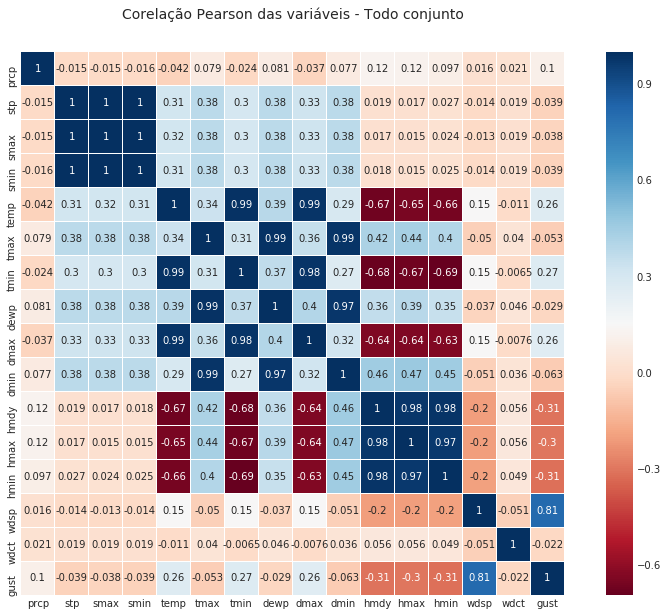

In [74]:
colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
plt.title(u'Corelação Pearson das variáveis - Todo conjunto', y=1.05, size=14)
svm = sns.heatmap(dfcont.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

fig = svm.get_figure()
name = '../graphs-br/pearson-base-all.png'
fig.savefig(name,dpi=200)

<p>Vamos fazer a correlação apenas com o subconjunto que tem as chuvas extremas e ver o resultado da correlação é similar (ao anterior) ou se durante o evento do evento extremo há alguma correlação </p>

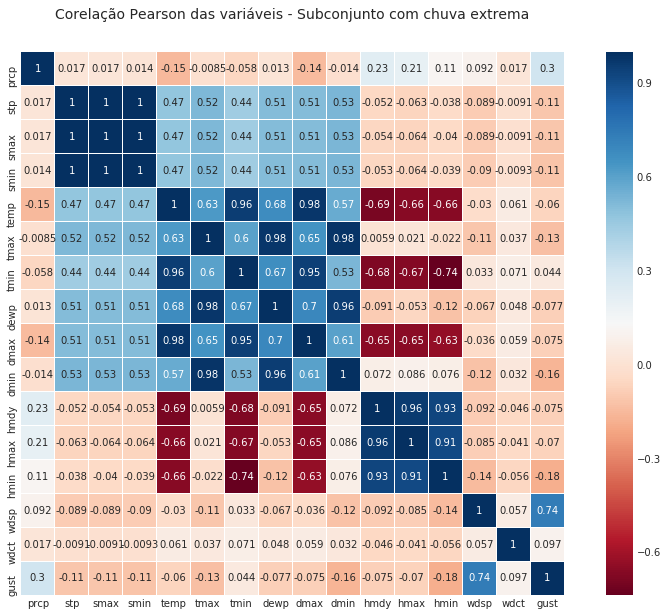

In [75]:
colormap = plt.cm.RdBu
plt.figure(figsize=(15,10))
plt.title(u'Corelação Pearson das variáveis - Subconjunto com chuva extrema', y=1.05, size=14)
svm = sns.heatmap(dfextcont.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

fig = svm.get_figure()
name = '../graphs-br/pearson-base-ext.png'
fig.savefig(name,dpi=200)

In [77]:
for f in DER:    
    dfextcont = dfextcont.drop(f, 1)

In [85]:
bins = np.linspace(dfextcont.prcp.min(), dfextcont.prcp.max(), 10)
dfextcont['prcp_bin'] = np.digitize(dfextcont.prcp, bins)

In [88]:
print(bins)

[  0.          11.11111111  22.22222222  33.33333333  44.44444444
  55.55555556  66.66666667  77.77777778  88.88888889 100.        ]


In [86]:
dfextcont.head(5)

,prcp,stp,temp,dewp,hmdy,wdsp,wdct,gust,prcp_bin
0,17.2,985.2,19.7,21.9,95.0,5.4,187.0,11.5,2
1,15.4,983.8,21.0,20.6,97.0,1.3,221.0,11.5,2
2,1.4,984.3,20.8,20.6,97.0,0.7,273.0,3.0,1
3,3.4,984.5,20.9,20.6,97.0,1.4,128.0,2.8,1
4,4.6,984.5,21.0,20.5,97.0,0.8,270.0,4.1,1


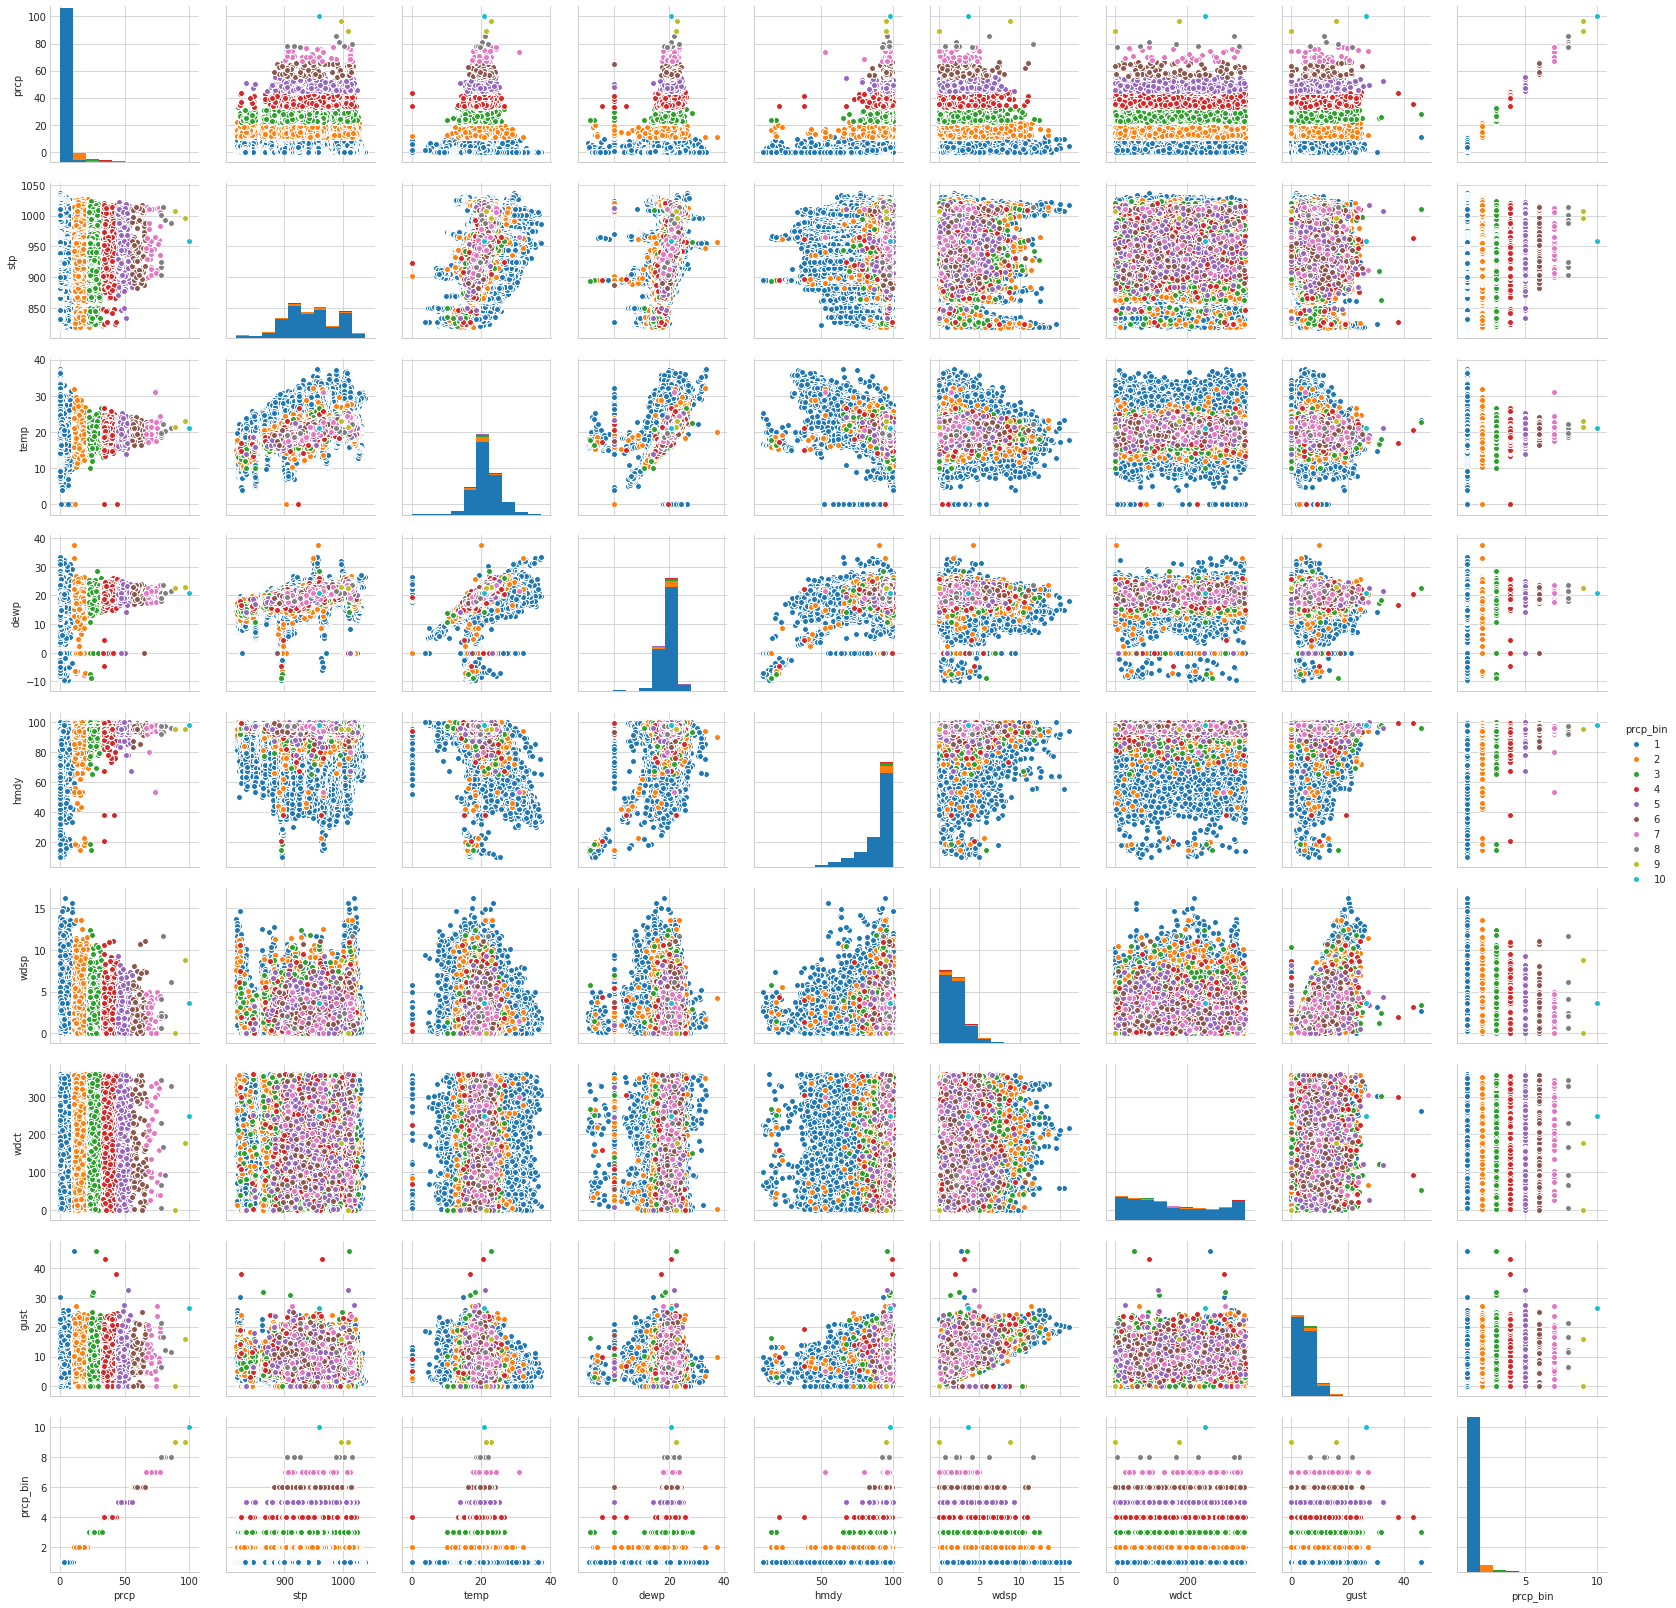

In [87]:
g = sns.pairplot(dfextcont,hue='prcp_bin')

In [89]:
name = '../graphs-br/pair_plot_hue.png'
g.savefig(name,dpi=100)